In [1]:
import argparse
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d
import sys
import time
import torch
import tqdm

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
from examples.mlp import mlp
from dist_ir.ir import Topology
from dist_ir.executor import infer_types, Simulator
from dist_ir.executor.cost_model import CostModel

In [3]:
DEVICE_THROUGHPUT = 6.7e12 # FLOPS
DRAM_BANDWIDTH = 2.7e12 # ???
PCIE_BANDWIDTH = 15.76 # Gbps
WORLD_SIZE = 2

In [4]:
class Mlp(torch.nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim):
        super().__init__()
        self.blocks = [
            torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_hidden_layers)
        ]
        for i, block in enumerate(self.blocks):
            for j, param in enumerate(block.parameters()):
                if j > 0:
                    raise ValueError(f"Block {i} has more than 1 parameter!")
                self.register_parameter(f"w{chr(ord('A')+i)}", param)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
            relu = torch.nn.ReLU()
            x = relu(x)
        return x

In [5]:
def run(
    num_hidden_layers,
    batch_size,
    hidden_dim,
    num_warmup_steps=10,
    num_profiling_steps=100,
):
    model = Mlp(num_hidden_layers, hidden_dim).to("cuda:0")
    loss_fn = torch.nn.MSELoss()
    x = torch.randn(size=(batch_size, hidden_dim)).to("cuda:0")
    labels = torch.randn(size=(batch_size, hidden_dim)).to("cuda:0")
    runtimes = []
    for i in tqdm.tqdm(range(num_warmup_steps + num_profiling_steps)):
        start = time.time()
        y = model(x)
        loss_fn(y, labels).backward()
        duration = time.time() - start
        runtimes.append(duration)
    return np.median(runtimes[num_warmup_steps:])

In [6]:
def simulate(num_hidden_layers, batch_size, hidden_dim):
    topology = Topology()
    d0 = topology.add_device(
        "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
    )
    function = mlp(
        batch_size, hidden_dim, hidden_dim, hidden_dim, num_hidden_layers, d0
    )
    function = infer_types(function, function.inputs)
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        function,
        (v.type for v in function.inputs),
    )
    return simulation.timestamps[d0]

In [7]:
def sweep(all_num_hidden_layers, all_batch_sizes, all_hidden_dims, filename, func):
    fieldnames = ["num_hidden_layers", "batch_size", "hidden_dim", "runtime"]
    with open(filename, "w") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for num_hidden_layers in all_num_hidden_layers:
            for batch_size in all_batch_sizes:
                for hidden_dim in all_hidden_dims:
                    runtime = func(num_hidden_layers, batch_size, hidden_dim)
                    writer.writerow(
                        {
                            "num_hidden_layers": num_hidden_layers,
                            "batch_size": batch_size,
                            "hidden_dim": hidden_dim,
                            "runtime": runtime,
                        }
                    )

In [8]:
def parse_csv(filename):
    results = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            results.append(
                (
                    row["num_hidden_layers"],
                    row["batch_size"],
                    row["hidden_dim"],
                    row["runtime"],
                )
            )
    return results

In [9]:
all_num_hidden_layers = [8, 16, 32]
all_batch_sizes = [512, 1024, 2048]
all_hidden_dims = [1024, 2048, 4096]
sweep(
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "single_device_runtimes.csv",
    run,
)
sweep(
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "single_device_simulated_runtimes.csv",
    simulate,
)

100%|██████████| 110/110 [01:25<00:00,  1.29it/s]


In [10]:
real_results = parse_csv("single_device_runtimes.csv")
simulated_results = parse_csv("single_device_simulated_runtimes.csv")

In [11]:
real_throughputs = []
simulated_throughputs = []
model_sizes = []
print(f"# layers,batch size,hidden dim,model size (MB),real,simulated,ratio")
for real, simulated in zip(real_results, simulated_results):
    num_hidden_layers = int(real[0])
    batch_size = int(real[1])
    hidden_dim = int(real[2])
    real_runtime = float(real[3])
    simulated_runtime = float(simulated[-1])
    model_size = hidden_dim * hidden_dim * num_hidden_layers * 4 / (1024 * 1024)
    print(
        f"{num_hidden_layers},{batch_size},{hidden_dim},"
        f"{model_size},{real_runtime*1000:.2f},"
        f"{simulated_runtime*1000:.2f},"
        f"{(simulated_runtime/real_runtime):.2f}x"
    )
    real_throughputs.append(batch_size / real_runtime / 1000)
    simulated_throughputs.append(batch_size / simulated_runtime / 1000)
    model_sizes.append(model_size)

# layers,batch size,hidden dim,model size (MB),real,simulated,ratio
8,512,1024,32.0,4.15,3.88,0.93x
8,512,2048,128.0,12.83,15.47,1.21x
8,512,4096,512.0,49.76,61.81,1.24x
8,1024,1024,32.0,6.76,7.74,1.15x
8,1024,2048,128.0,24.26,30.89,1.27x
8,1024,4096,512.0,89.29,123.42,1.38x
8,2048,1024,32.0,12.55,15.47,1.23x
8,2048,2048,128.0,45.26,61.73,1.36x
8,2048,4096,512.0,174.24,246.65,1.42x
16,512,1024,64.0,7.91,7.75,0.98x
16,512,2048,256.0,26.86,30.94,1.15x
16,512,4096,1024.0,103.13,123.62,1.20x
16,1024,1024,64.0,13.88,15.48,1.12x
16,1024,2048,256.0,51.19,61.78,1.21x
16,1024,4096,1024.0,187.04,246.84,1.32x
16,2048,1024,64.0,26.25,30.94,1.18x
16,2048,2048,256.0,97.14,123.46,1.27x
16,2048,4096,1024.0,373.09,493.28,1.32x
32,512,1024,128.0,16.37,15.51,0.95x
32,512,2048,512.0,55.16,61.88,1.12x
32,512,4096,2048.0,213.56,247.24,1.16x
32,1024,1024,128.0,30.98,30.96,1.00x
32,1024,2048,512.0,102.98,123.56,1.20x
32,1024,4096,2048.0,385.71,493.68,1.28x
32,2048,1024,128.0,57.25,61.87,1.08x
32,2048,2048,512

Pearson's correlation: 0.9896481585373098


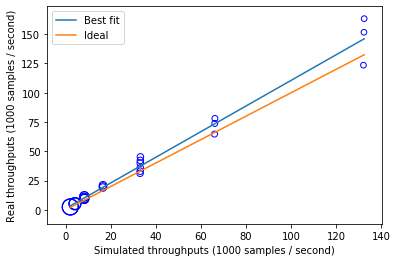

In [12]:
simulated_throughputs = np.array(simulated_throughputs)
real_throughputs = np.array(real_throughputs)
r = np.corrcoef(simulated_throughputs, real_throughputs)[0,1]
print("Pearson's correlation:", r)
m, b = np.polyfit(simulated_throughputs, real_throughputs, 1)
x_new = np.linspace(simulated_throughputs.min(), simulated_throughputs.max(), 500)
f = interp1d(simulated_throughputs, m * simulated_throughputs + b, kind="linear")
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, label="Best fit")
plt.plot(x_new, x_new, label="Ideal")
colors=["b", "orange", "g", "purple"]
scaled_model_sizes = np.array(model_sizes, dtype=np.float32)
scaled_model_sizes -= np.min(model_sizes)
scaled_model_sizes *= 1.0 / (np.max(model_sizes) - np.min(model_sizes))
scaled_model_sizes *= 224
scaled_model_sizes += 32
plt.scatter(
    simulated_throughputs,
    real_throughputs,
    s=scaled_model_sizes,
    facecolors="none",
    edgecolors="b",
)
plt.xlabel("Simulated throughputs (1000 samples / second)")
plt.ylabel("Real throughputs (1000 samples / second)")
plt.legend()
plt.savefig("single_device_simulation_performance.pdf", dpi=600, bbox_inches="tight")